In [ ]:
!pip install eli5 shap catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

# ML
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


# Tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap
import graphviz

In [ ]:
def contours2D(model, x1, x2, h=0.01, **params):
  xx1, xx2 = np.meshgrid(
    np.arange(x1.min() - 0.1, x1.max() + 0.1, h), 
    np.arange(x2.min() - 0.1 , x2.max() + 0.1 , h)
  )

  y = model.predict(np.c_[xx1.flatten(), xx2.flatten()])
  y = y.reshape(xx1.shape)
  result = plt.contourf(xx1, xx2, y, **params)
  return result


# SVR(Support Vector Regression)

In [ ]:
np.random.seed(123)
x = np.linspace(-1, 1, 100)
y = x ** 2 + 1.5 * x + 0.5 * (2 * np.random.rand(len(x))-1)

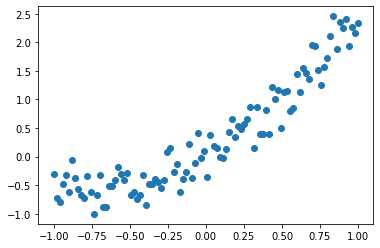

In [ ]:
plt.plot( x, y, 'o')
plt.show()

- SVM은 가우시안 커널(RBF)을 이용
  - 추정해야 되는 파라미터 `C`, `gamma`
  - C와 gamma는 커지면 커질수록 과적합 되는 경향

In [ ]:
model = SVR(C=1000, gamma=1000).fit( x.reshape(-1, 1), y)

In [ ]:
model.score( x.reshape(-1,1), y)

0.9899827980477481

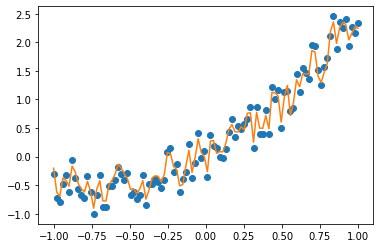

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, model.predict( x.reshape(-1,1)))
plt.show()

## 과적합
- SVM 같은 경우 적절한 C와 Gamma를 찾아서 과적합을 해결
- GridSearch를 활용하여 C와 Gamma 추정

In [ ]:
params = {
  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}


model = SVR()
search = GridSearchCV(model, param_grid=params, scoring='r2', cv=10)
results = search.fit(x.reshape(-1, 1), y)

In [ ]:
print(results.best_params_)
print(results.best_score_)

{'C': 100, 'gamma': 0.1}
-0.2214765441717212


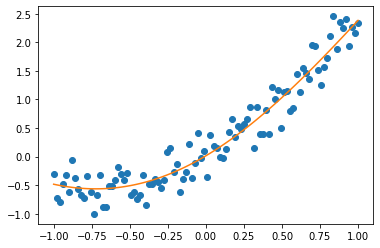

In [ ]:
best_model = results.best_estimator_

plt.plot(x, y, 'o')
plt.plot(x, best_model.predict( x.reshape(-1,1)))
plt.show()

## 캘리포니아 집값 예측


In [ ]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
validation = pd.read_csv('/content/sample_data/california_housing_test.csv')

In [ ]:
train_features = train.drop( columns=['median_house_value', 'longitude', 'latitude'])
train_target = train['median_house_value']
validation_features = validation.drop( columns=['median_house_value', 'longitude', 'latitude'])
validation_target = validation['median_house_value']

In [ ]:
kfolds = KFold(n_splits=10 ,shuffle=True)

In [ ]:
params = {
  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}


model = SVR()
search = GridSearchCV(model, param_grid=params, scoring='r2', cv=kfolds)
results = search.fit(train_features, train_target)

In [ ]:
print( results.best_params_ )
best_model = results.best_estimator_

{'C': 1000, 'gamma': 0.001}


In [ ]:
yhat = best_model.predict( validation_features )
r2 = r2_score( validation_target, yhat )
mse = mean_squared_error( validation_target, yhat )
mae = mean_absolute_error( validation_target, yhat )
print( f'r2: {r2}, mse: {mse}, mae: {mae}')

r2: -0.04625104181710005, mse: 13383432338.543594, mae: 86402.60994050592


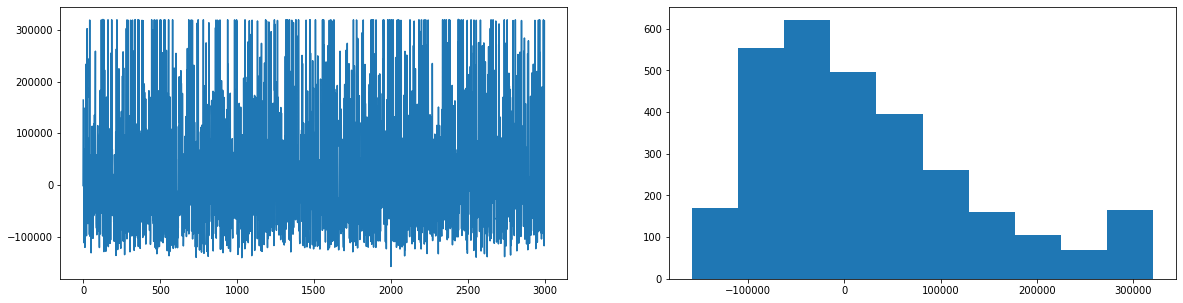

In [ ]:
residual = validation_target - yhat

plt.figure( figsize=(20, 5) )

plt.subplot( 1, 2, 1)
plt.plot( residual )

plt.subplot( 1, 2, 2)
plt.hist( residual )

plt.show()

### 일부 변수만 사용

In [ ]:
train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [ ]:
train_features = train.drop( columns=['median_house_value', 'longitude', 'latitude', 'total_rooms', 'housing_median_age'])
train_target = train['median_house_value']
validation_features = validation.drop( columns=['median_house_value', 'longitude', 'latitude', 'total_rooms', 'housing_median_age'])
validation_target = validation['median_house_value']

In [ ]:
train_features

,total_bedrooms,population,households,median_income
0,1283.0,1015.0,472.0,1.4936
1,1901.0,1129.0,463.0,1.8200
2,174.0,333.0,117.0,1.6509
3,337.0,515.0,226.0,3.1917
4,326.0,624.0,262.0,1.9250
...,...,...,...,...
16995,394.0,907.0,369.0,2.3571
16996,528.0,1194.0,465.0,2.5179
16997,531.0,1244.0,456.0,3.0313
16998,552.0,1298.0,478.0,1.9797


### 스케일링

In [75]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform( train_features )
train_features_scaled

array([[ 1.76420407, -0.36118401, -0.07599796, -1.25254316],
       [ 3.23044127, -0.26186523, -0.09940441, -1.08148298],
       [-0.86695622, -0.95535424, -0.99925206, -1.17010515],
       ...,
       [-0.01995512, -0.16167524, -0.11760942, -0.44666313],
       [ 0.02986848, -0.1146295 , -0.06039367, -0.99778717],
       [-0.56801465, -0.54326844, -0.60134255, -0.45536288]])

검증 자료도 동일하게 스케일링을 해줍니다.

In [ ]:
validation_features_scaled = scaler.fit_transform( validation_features )
validation_features_scaled

array([[ 0.31533695,  0.13024561,  0.31773437,  1.51074547],
       [-0.52925544, -0.57629585, -0.58274291, -0.11232419],
       [-0.05522495,  0.07880784,  0.01392592,  1.0711495 ],
       ...,
       [-0.79153626, -0.68887663, -0.73875265, -0.81855768],
       [-1.24150429, -1.31680565, -1.30257733, -0.2893275 ],
       [-0.642349  , -0.63064519, -0.62927213,  2.56365089]])

In [ ]:
params = {
  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

model = SVR()
search = GridSearchCV( model, param_grid=params, scoring='r2', cv=kfolds)
results = search.fit( train_features_scaled, train_target )

In [ ]:
print( results.best_params_ )
best_model = results.best_estimator_

{'C': 1000, 'gamma': 0.1}


In [ ]:
yhat = best_model.predict( train_features_scaled )
r2 = r2_score( train_target, yhat )
mse = mean_squared_error( train_target, yhat )
mae = mean_absolute_error( train_target, yhat )
print( f'r2: {r2}, mse: {mse}, mae: {mae}')

r2: 0.519041096360758, mse: 6469590937.881319, mae: 58408.18554213965


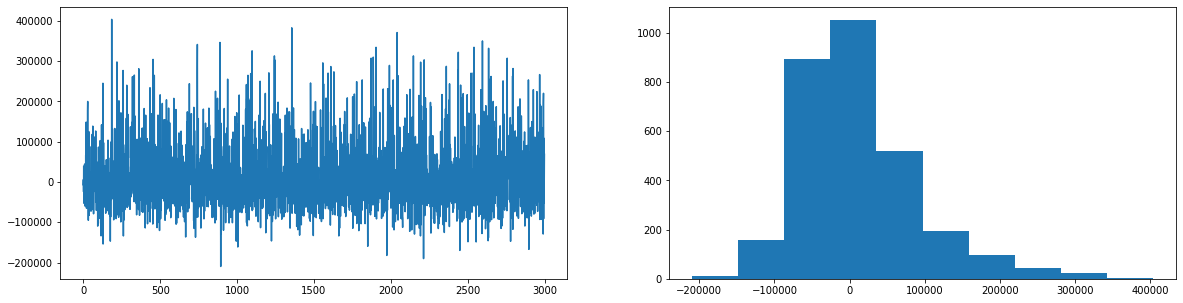

In [ ]:
residual = validation_target - yhat

plt.figure( figsize=(20, 5) )

plt.subplot( 1, 2, 1)
plt.plot( residual )

plt.subplot( 1, 2, 2)
plt.hist( residual )

plt.show()

## 정리


> 알고리즘만 이용해서 좋은 모델을 찾을 수는 없습니다. 추가적으로 설명력이 높은 변수와 다양한 전처리를 통해서 모델을 업데이트 하는 방향도 생각을 해봐야 합니다. 

# KNN(K-Nearst Neighbors)
- K - 최근접 이웃 알고리즘
  - 다수결의 원칙에 따라서, 주어진 값의 근처에 있는 Y의 개수가 많은 쪽으로 분류
  - 거리에 따라서 가중치를 줄 수도 있습니다.

![](https://blog.kakaocdn.net/dn/bJ2ECl/btqM5fWzhmv/U2Qz5DMgCvYqsTCpNn7woK/img.png)

- 중요한것은 적절한 파라미터 `K`는? 
  - K가 너무 작으면 과적합이 될 수 있고
  - K가 너무 크면 과소적합이 될 수 있습니다.
  - 이진 분류의 경우에 k는 홀수를 이용합니다(동률이 나오지 않도록)


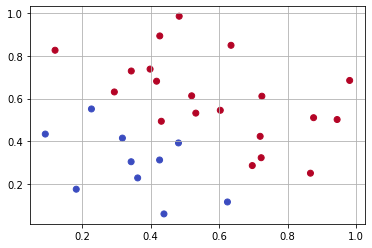

In [ ]:
np.random.seed(123)
x = np.random.rand(30,2)
y = np.zeros(len(x))
y[-4/5 + 3/4 * x[:,0] + 1 * x[:,1] > 0] = 1

x1, x2 = x[:,0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

- KNN 파라미터
1. n_neighbors
  - K값의 의미합니다.
  - 주변의 몇개까지 확인 할 것인지

2. weights
  - 기본값은 uniform 입니다.
  - `distance`를 사용하면 거리에 기반해서 가중치를 두게 됩니다.

## 분류

In [ ]:
model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
model.fit(x, y)

KNeighborsClassifier(n_neighbors=3)

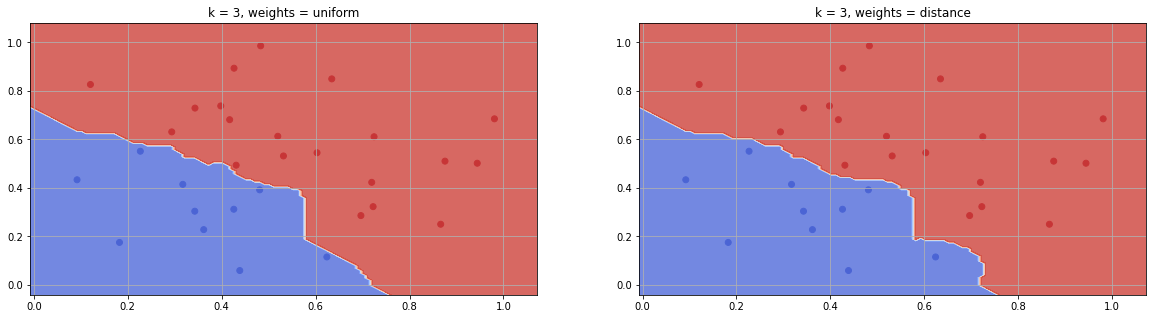

In [ ]:
plt.figure( figsize=(20, 5))

plt.subplot( 1, 2, 1)
model = KNeighborsClassifier(n_neighbors=3, weights='uniform').fit(x, y)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
contours2D( model, x1, x2, cmap='coolwarm', alpha=0.8 )
plt.title('k = 3, weights = uniform')
plt.grid()

plt.subplot( 1, 2, 2)
model = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(x, y)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
contours2D( model, x1, x2, cmap='coolwarm', alpha=0.8 )
plt.title('k = 3, weights = distance')
plt.grid()

plt.show()

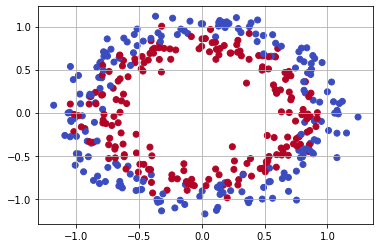

In [ ]:
x, y = datasets.make_circles(n_samples=400, noise=0.1, random_state=410)
x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

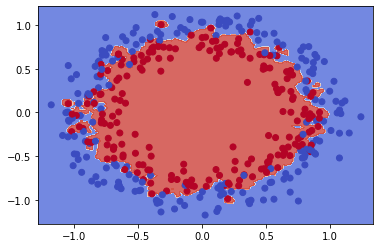

In [ ]:
model = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(x, y)
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

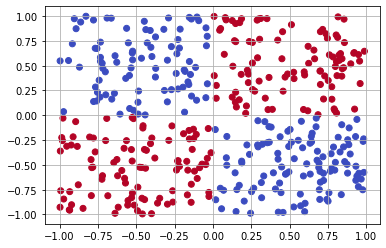

In [ ]:
np.random.seed(410)
x = np.random.uniform(-1,1, (400,2))
y = np.zeros((400), dtype=np.int32)
y[ x[:,0] * x[:,1] > 0] = 1

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

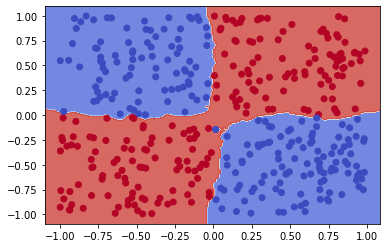

In [ ]:
model = KNeighborsClassifier(n_neighbors=11, weights='distance').fit(x, y)
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

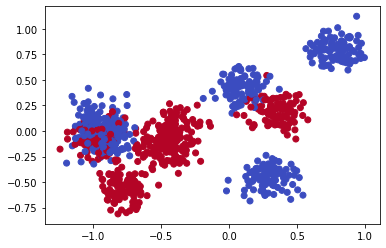

In [ ]:
x, y = datasets.make_blobs( 
  n_samples=1000, center_box=(-1, 1), centers=10, cluster_std=0.1, random_state=3)
y %= 2

x1, x2 = x[:, 0], x[:, 1]
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.show()

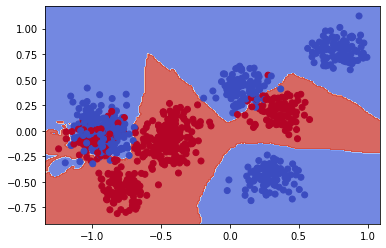

In [ ]:
model = KNeighborsClassifier(n_neighbors=11, weights='distance').fit(x, y)
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## 회귀

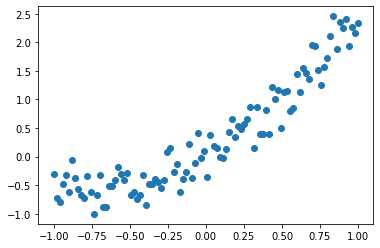

In [ ]:
np.random.seed(123)
x = np.linspace(-1, 1, 100)
y = x ** 2 + 1.5 * x + 0.5 * (2 * np.random.rand(len(x))-1)

plt.plot( x, y, 'o')
plt.show()

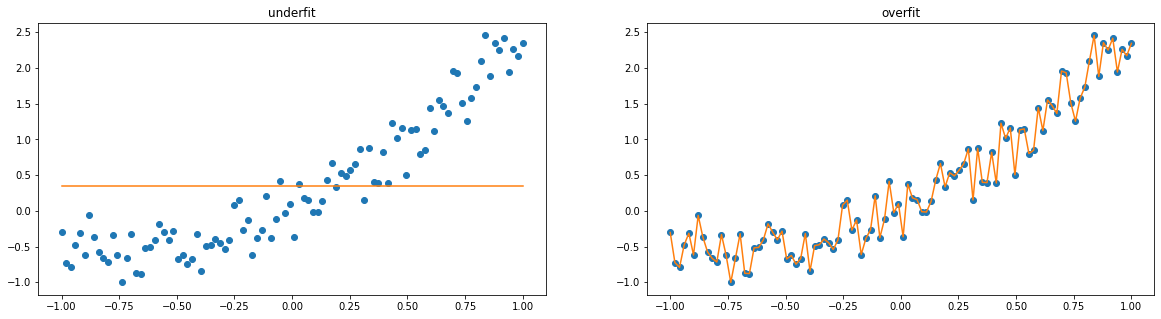

In [ ]:
plt.figure( figsize=(20, 5))

plt.subplot(1, 2, 1)
model = KNeighborsRegressor(n_neighbors=100, weights='uniform').fit(x.reshape(-1,1), y)
plt.plot( x, y, 'o')
plt.plot( x, model.predict( x.reshape(-1,1)))
plt.title('underfit')

plt.subplot(1, 2, 2)
model = KNeighborsRegressor(n_neighbors=100, weights='distance').fit(x.reshape(-1,1), y)
plt.plot( x, y, 'o')
plt.plot( x, model.predict( x.reshape(-1,1)))
plt.title('overfit')

plt.show()

### 최적의 파라미터는?

In [ ]:
kfolds = KFold( n_splits=10, shuffle=True)

In [ ]:
params = {
  'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
  'weights': ['uniform', 'distance'],
}

model = KNeighborsRegressor()
search = GridSearchCV( model, param_grid=params, scoring='r2', cv=kfolds)
results = search.fit( x.reshape(-1,1), y )

In [ ]:
print(results.best_params_)

{'n_neighbors': 9, 'weights': 'uniform'}


In [ ]:
best_model = results.best_estimator_

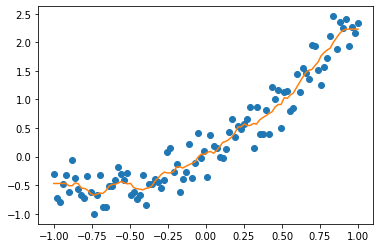

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, best_model.predict( x.reshape(-1,1)))
plt.show()

# Decision Tree(결정트리)
- 선형회귀, SVM, KNN 등의 특징은?
  - 선 하나로 전부 분류
- 결정트리는 여러개의 선으로 분류를 시도
  - 일반적으로 정확도가 높은 것을 잘 알려져 있습니다.
  - 단점은 트리의 깊이가 깊어질 수록 과적합이 됩니다.

- 앙상블 기법은 어떤 알고리즘을 사용해도 상관 없지만
  - 결정트리를 주로 많이 사용을 합니다. 

## 파라미터
![](https://www.mastersindatascience.org/wp-content/uploads/tree-graphic.jpg)

- Rood Node: 트리의 최상단 노드
- leaf nodes: 트리의 가장 마지막 노드(terminal node)
- level: 트리가 분할 됐을때의 깊이(depth)
- depth: 전체 트리의 깊이(가장 마지막 노드의 레벨)
  - depth가 깊으면 깊을수록 과적합 되기 쉽습니다.


- 파라미터
  1. criterion: 'gini'(default), 'entropy'
    - gini(불순도), entropy(복잡도)

  2. max_depth: 만들어질 트리의 최대 깊이를 지정
    - 과적합과 관련된 파라미터로 추후에 `pruning(가지치기)`할 때 사용하는 파라미터
  
  3. min_sample_split: 노드를 분할하기 위한 샘플의 최소 개수
    - 과적합과 관련된 파라미터
    - 기본값은 2이고, 작게설정할수록 분할이 많이 발생하고 분할이 많이 되면 될 수록 과적합될 가능성이 높아집니다.

  4. min_sample_leaf: 마지막 노드가 되기 위한 샘플의 최소 개수
    - 과적합과 관련된 파라미터
    - 클래스간 불균형이 있을 경우에 설정
    - 특정 클래스의 비율이 극도로 작을 경우 이 값을 작게 설정할 필요가 있다.

  5. max_features: 트리를 구성할 변수의 최대 개수
    - 기본값은 모든 변수를 사용해서 트리를 구성
    - 정수로 지정하면 사용할 변수의 개수, 실수로 지정하면 사용할 변수의 비율
    - 정수, 실수, 'sqrt', 'log2' 중에 하나로 셋팅

  6. max_leaf_nodes: 마지막 노드의 최대 개수
    - max_depth와 동일한 파라미터
    - max_depth를 지정한 경우 이 파라미터는 굳이 셋팅하지 않아도 됩니다.
    - 최대깊이를 지정하게 되면 최대 마지막 노드의 개수도 정해지게 되고, 최대 마지막 노드의 개수가 정해지면 최대 깊이 또한 정해지게 됩니다. 
  

## 분류

In [ ]:
# 기본 파라미터로 사용
model = DecisionTreeClassifier().fit(x, y)

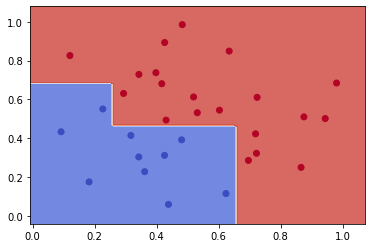

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

### 트리 시각화
- `graph_viz`를 사용해서 어떻게 트리가 구성되었는지 확인

In [ ]:
from sklearn.tree import export_graphviz

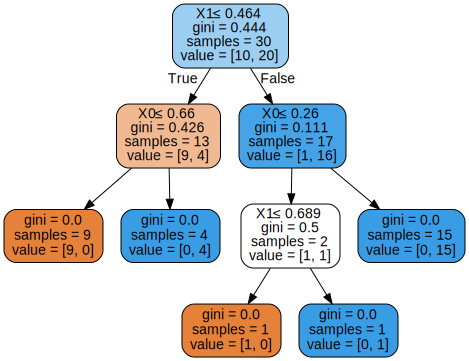

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

### 과적합
- 트리는 기본적으로 최대 깊이까지 만들게 되면 과적합
- 그렇기 때문에, 최대깊이를 지정해주는 것으로 과적합을 예방(푸르닝/가지치기)

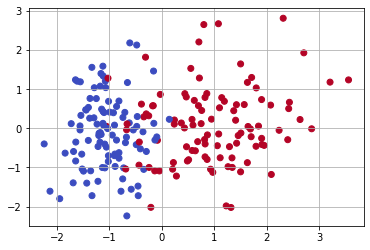

In [ ]:
x, y = datasets.make_classification(
  n_samples=200, n_features=2, n_classes=2, random_state=20220214,
  n_informative=1, n_redundant=0, n_clusters_per_class=1,
)

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
model = DecisionTreeClassifier().fit(x, y)

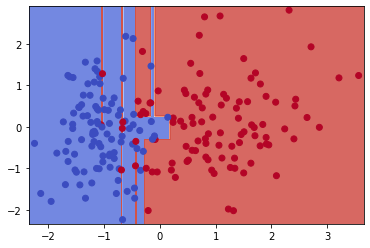

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

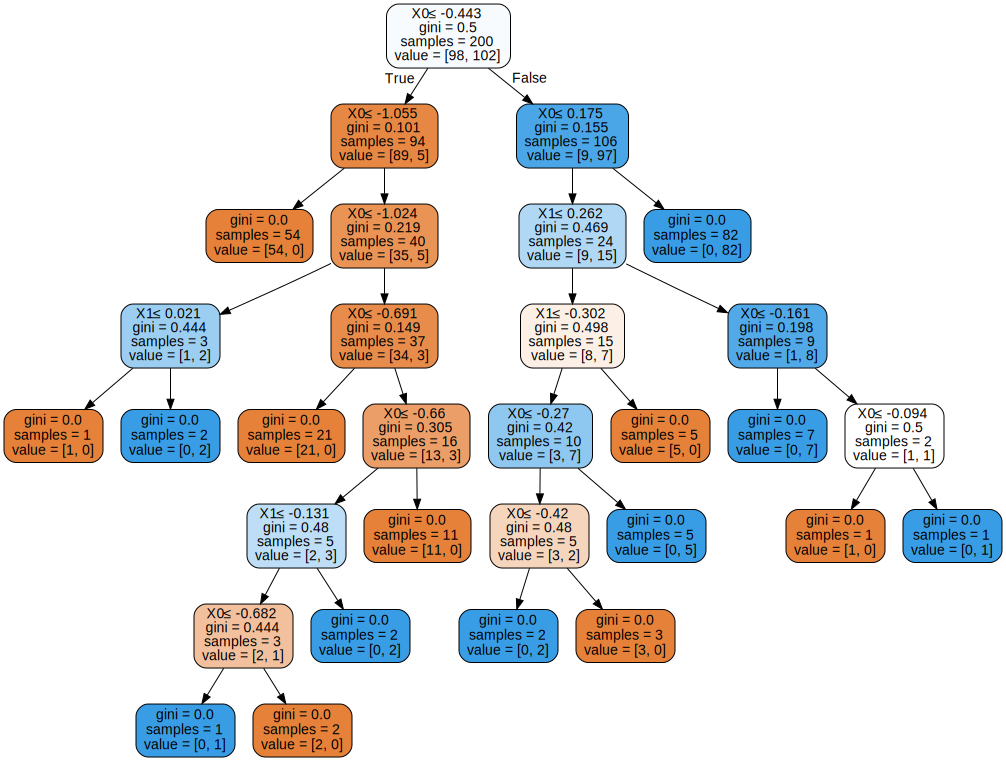

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

#### Pruning(가지치기)
- 트리의 최대깊이를 제한함으로써, 더 이상 노드가 새로 생기지 않도록 억제

In [ ]:
model = DecisionTreeClassifier(max_depth=4).fit(x, y)

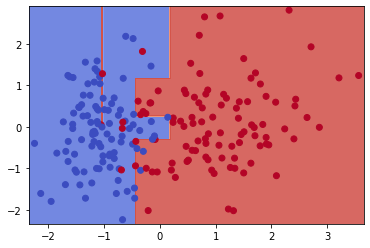

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

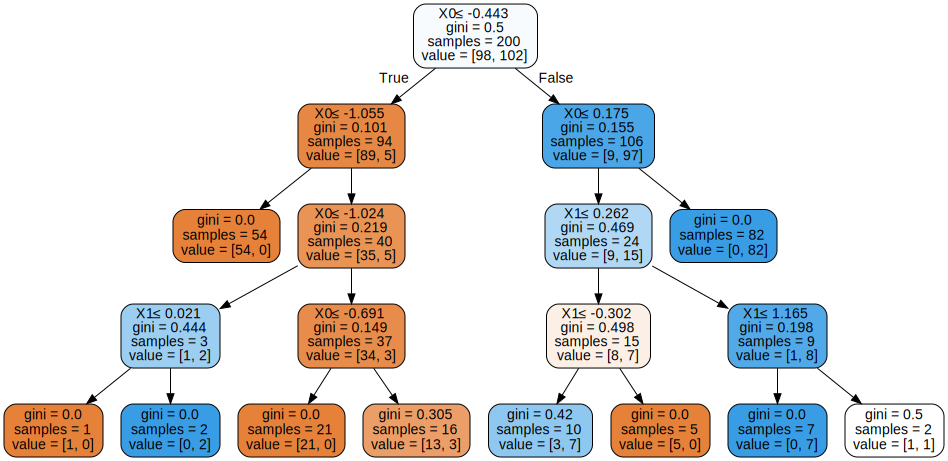

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

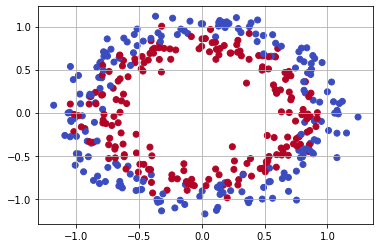

In [ ]:
x, y = datasets.make_circles(n_samples=400, noise=0.1, random_state=410)
x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
model = DecisionTreeClassifier(max_depth=9).fit(x, y)

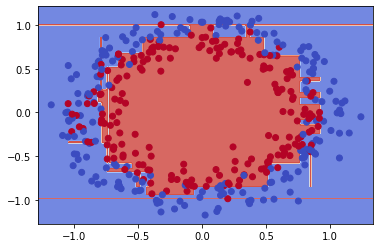

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

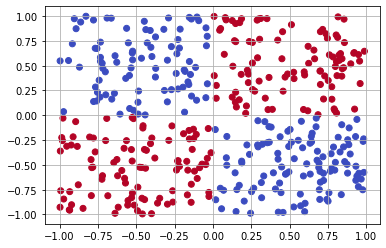

In [ ]:
np.random.seed(410)
x = np.random.uniform(-1,1, (400,2))
y = np.zeros((400), dtype=np.int32)
y[ x[:,0] * x[:,1] > 0] = 1

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
model = DecisionTreeClassifier().fit(x, y)

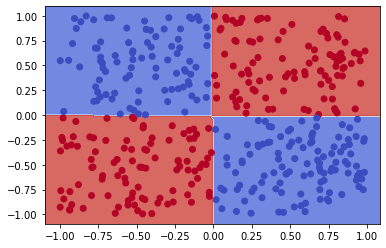

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

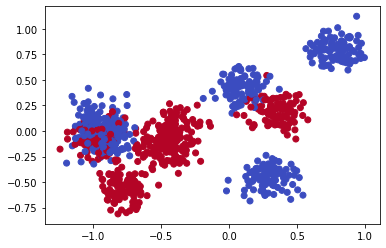

In [ ]:
x, y = datasets.make_blobs( 
  n_samples=1000, center_box=(-1, 1), centers=10, cluster_std=0.1, random_state=3)
y %= 2

x1, x2 = x[:, 0], x[:, 1]
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='coolwarm')

In [ ]:
model = DecisionTreeClassifier(max_depth=4).fit(x, y)

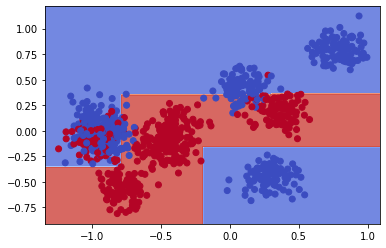

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## 회귀

In [ ]:
np.random.seed(123)
x = np.linspace(-1, 1, 100)
y = x ** 2 + 1.5 * x + 0.5 * (2 * np.random.rand(len(x))-1)

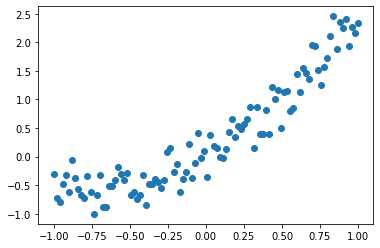

In [ ]:
plt.plot( x, y, 'o')

In [ ]:
model = DecisionTreeRegressor().fit(x.reshape(-1,1),y)

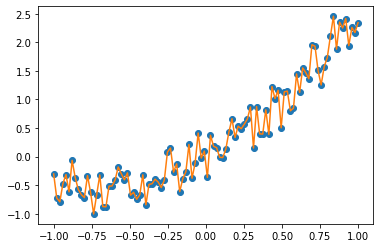

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, model.predict( x.reshape(-1,1)))
plt.show()

### 파라미터 추정

In [ ]:
params = {
  'criterion': ['squared_error', 'absolute_error'],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'min_samples_split': [20, 30, 40]
}

model = DecisionTreeRegressor()
search = GridSearchCV( model, param_grid=params, scoring='r2', cv=10)
results = search.fit( x.reshape(-1,1), y )

In [ ]:
print( results.best_params_)
best_model = results.best_estimator_

{'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 20}


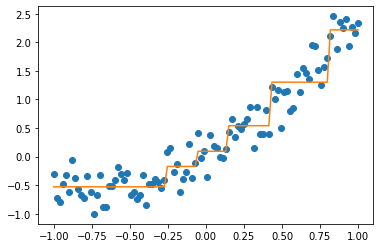

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, best_model.predict( x.reshape(-1,1)))
plt.show()

# Ensemble(앙상블)
- 모형을 하나만 사용하지 않고, 여러개의 모델을 이용해서 정확도를 높이려는 방법

  1. Bagging(배깅)
    - RandomForest(정확도가 높기로 유명한 방법)
    - 과적합에 강하다고 알려져 있습니다.
  2. Boosting(부스팅)
    - XgBoost, LightGBM, CatBoost
    - 정확도가 낮을 때 사용하면 좋다고 알려져 있습니다.

- 배깅과 부스팅은 여러개의 모델을 병렬로 연결하느냐 직렬로 연결하느냐의 차이
- 경험상 어떤 방법이 더 좋다 라고 콕 집어서 얘기할 수는 없을 것 같습니다. 
  - 현실세계의 자료는 워낙 다양하기 때문에 정확하게 얘기하기에는 힘들 것 같습니다.

- 앙상블 기법은 반드시 결정트리를 사용해야만 하는 것은 아닙니다.
  - 하지만, 많은 라이브러리들이 결정트리를 기반으로 동작
  - 실습에서도 결정트리를 사용해보도록 하겠습니다.
  

## Bootstrapping
- 원본 자료에서 여러개의 샘플을 추출하는 방법(Sub Sampling)
- 교차검증에서 교차검증셋을 만드는 방법과는 차이가 있습니다.
  - 교차검증과는 원본자료에서 중복이 가능한 형태로 여러개의 서브 샘플을 만들 수 있습니다. 
  - 원본셋에서 만들 수 있는 조합의 경우의 수를 가지고 만들어 집니다.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png)

- 그림에서는 배깅과 함께 설명하고 있지만, 배깅과 부스팅 모두 동일하게 사용하는 서브 샘플링 방법입니다.
  - 생성된 서브 샘플링된 셋을 병렬로 연결, 직렬로 연결하느냐의 차이

## Bagging

![](https://gaussian37.github.io/assets/img/ml/concept/bagging/bagging.png)

앞서 살펴봤던 샘플등 중에서 가장 결과가 좋지 않았던 샘플을 사용

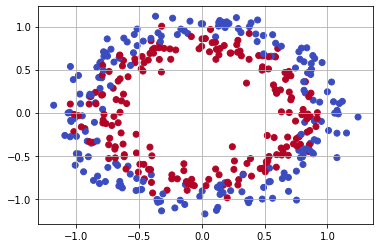

In [ ]:
x, y = datasets.make_circles(n_samples=400, noise=0.1, random_state=410)
x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

일반적으로 서브 샘플들은 라이브러리 내에서 자동으로 처리가 됩니다.

### 부트스트래핑
- 실습시간에는 직접 샘플을 만들어서 적용해봅니다.

In [ ]:
subSamples = []
for _ in range(11):
  # 서브 샘플을 만들기 위해서 인덱스를 추출
  idx = [x for x in range(x.shape[0])]
  
  # 생성된 인덱스들 중에서 랜덤하게 인덱스를 고릅니다.
  # 400개의 데이터에서 200개를 고르는 조합을 찾는 겁니다.
  sample = np.random.choice( idx, x.shape[0] // 2, replace=False )
  
  # 10개의 조합을 생성해서 확인
  subSamples.append( sample )

In [ ]:
subSamples

[array([ 30, 224, 131, 161, 250,  90,  76, 242, 257, 324,  26, 386,  27,
        260, 280,  38, 319, 379,   7,  12, 233, 123,  52, 331,  77,  37,
        390, 301, 227, 381, 383, 274, 273, 118, 313,  80, 168, 314, 357,
         63, 253, 108,  99, 105,  14,  93, 137, 376, 158,  20,  19, 302,
        382, 310, 226, 179, 223, 251, 199, 298, 169,  43,  10,  71, 344,
         70, 106, 219, 136, 285, 172, 284, 116, 356, 183, 330, 293, 329,
        218, 259, 149, 100,  66, 385, 232,  96, 294, 342, 325, 114, 397,
        157, 150, 230, 398, 177, 317, 216, 197, 198, 350, 236, 145, 210,
        171, 334, 275, 264, 269, 309,  44, 194, 225, 204, 306, 349,  17,
        307,  55, 178,  95,  35, 239,  84, 247, 166, 229,  89, 104,  23,
        244, 371,  57, 206, 163, 195, 203, 182, 170, 185,   9,   2, 127,
        333, 358,  39, 297, 139, 184,  51,  18, 318, 121, 316,  79, 235,
        303, 142, 212, 365, 292,  65, 175,  32, 295, 248, 286, 373,  92,
        246, 375, 378,  68, 151,  85,  69, 374, 355

### 배깅
- 위에서 생성된 10개의 서브샘플을 이용해서 10개의 모델을 만들어 봅니다.

In [ ]:
bagging = []
for idx in subSamples:
  x_train = x[idx]
  y_train = y[idx]
  model = DecisionTreeClassifier().fit(x_train, y_train)
  bagging.append( model.predict(x) )

In [ ]:
# 예를 들어서 두번째 값에 대한 10개의 모델의 예측 결과를 확인해보면
for predict in bagging:
  print( predict[1] )

1
0
0
0
0
0
1
0
0
0
0


- 2개의 모델은 1로 판단, 나머지는 0으로 판단
  - 하드보팅인 경우에는 가장 많이 투표한 결과를 최종 결과로 사용

### 랜덤포레스트
- 결정트리를 이용한 대표적인 배깅 알고리즘 입니다.
- 파라미터
  1. n_estimators: 트리의 개수
    - 즉, 서브샘플링 개수
  2. 나머지는 결정트리의 파라미터와 동일한 내용

- 책에서의 예제와는 다르기는 하지만, 비슷하게 파라미터를 추정 해보겠습니다. 

In [ ]:
params = {
  'criterion': ['gini', 'entropy'],
  # 원본셋의 개수가 400개 이므로, 서브샘플의 개수는 그보다 작아야 합니다.
  'n_estimators': [100, 300, 500, 1000],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'min_samples_split': [8, 16, 20],
  'min_samples_leaf': [8, 12, 18],
}

model = RandomForestClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=10)
results = search.fit( x, y )

- 안타깝지만 여기서 종료 하도록 하겠습니다.
- 나머지 확인은 추후에 직접 해보시길 바랍니다.

## Boosting
![](https://jinsu-l.github.io/assets/post_images/image-20191217222322387.png)

- 부트스트래핑 과정까지는 배깅과 동일
- 그 이후에, 약한 분류기로부터 오분류된 내용에 가중치를 둬서 다음 모델에 반영하는 방식
  - 그렇기 때문에 학습이 진행될 수록 정확도가 높아지는 경향
  - 과적합 되기 쉬운 모델이다 라고 알려져 있습니다.

### XGBoost
- 캐글에서 높은 정확도를 내기 시작하면서 잘 알려지기 시작
- 일반 파라미터
  - booster: gbtree(tree based model/default), gblinear(linear model)
  - nthread: 실행 스레드 개수를 조절해서 분산처리가 가능, CPU의 코어 개수에 따라서 저절한 값을 셋팅

- 부스터 파라미터
  - eta: 학습율과 동일한 의미, default(0.3), 0에서 1사이의 값으로 세팅
  - num_boost_rounds: n_estimator와 동일한 의미
  - max_depth
  - sub_sample: 샘플링 비율
  - colsample_bytree, colsample_bylevel, colsample_bynode: 트리별, 레벨별, 노드별 샘플링 비율
  - lambda: L2 규제
  - alpha: L1 규제

- 학습과 관련된 파라미터
  - objective: 손실함수
    - 보통은 회귀모델인지 분류모델인지에 따라서 구분, 분류모델인 경우에는 추가적으로 바이너리, 멀티카테고리인지 정도만 적용
  - eval_metric: 평가방법

- 그외에 자세한 파라미터는 홈페이지를 참조
  - [XGBoost Parameter](https://xgboost.readthedocs.io/en/stable/parameter.html)

실제로 전부 추정하려면 시간이 너무 오래 걸리므로 파라미터를 줄여서 확인

In [ ]:
params = {
  'eta': [0.01, 0.001],
  'num_boost_rounds': [100, 300, 500],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'objective': ['binary:hinge']
}

model = xgb.XGBClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=5)
results = search.fit( x, y )

In [ ]:
print( results.best_params_ )
best_model = results.best_estimator_

{'eta': 0.01, 'max_depth': 3, 'num_boost_rounds': 100, 'objective': 'binary:hinge'}


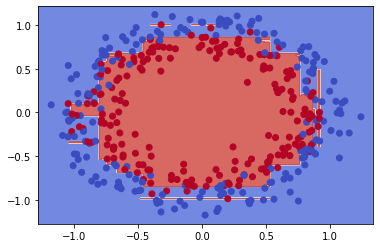

In [ ]:
contours2D(best_model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

### LightGBM
- XGBoost 단점인 속도를 개선한 알고리즘
- 파라미터는 XGBoost와 거의 동일하게 사용
  - 자세한 파라미터는 홈페이지 참조
  - [LightGBM Parameter](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [ ]:
params = {
  'learning_rate': [0.01, 0.001],
  'num_iterations ': [100, 300, 500],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'objective': ['binary']
}

model = lgb.LGBMClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=5)
results = search.fit( x, y )

In [ ]:
print( results.best_params_ )
best_model = results.best_estimator_

{'learning_rate': 0.01, 'max_depth': 9, 'num_iterations ': 100, 'objective': 'binary'}


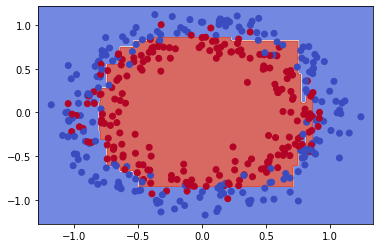

In [ ]:
contours2D(best_model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

### CatBoost
- 자료가 범주형인 경우에 굉장히 잘 동작한다고 알려져 있습니다. 
- 별 다른 파라미터 추정을 하지 않아도 알아서 좋은 결과를 내줍니다.

In [ ]:
model = cb.CatBoostClassifier().fit(x, y)

Learning rate set to 0.006966
0:	learn: 0.6906462	total: 49.6ms	remaining: 49.6s
1:	learn: 0.6884001	total: 50.4ms	remaining: 25.2s
2:	learn: 0.6860735	total: 51.2ms	remaining: 17s
3:	learn: 0.6839346	total: 52ms	remaining: 12.9s
4:	learn: 0.6816658	total: 55.9ms	remaining: 11.1s
5:	learn: 0.6789914	total: 59.9ms	remaining: 9.93s
6:	learn: 0.6764810	total: 61.1ms	remaining: 8.67s
7:	learn: 0.6740872	total: 62.4ms	remaining: 7.74s
8:	learn: 0.6715738	total: 63.3ms	remaining: 6.97s
9:	learn: 0.6695618	total: 64.1ms	remaining: 6.34s
10:	learn: 0.6675955	total: 64.9ms	remaining: 5.83s
11:	learn: 0.6653240	total: 74.6ms	remaining: 6.14s
12:	learn: 0.6634218	total: 75.6ms	remaining: 5.74s
13:	learn: 0.6609600	total: 76.4ms	remaining: 5.38s
14:	learn: 0.6575228	total: 77.2ms	remaining: 5.07s
15:	learn: 0.6556575	total: 85ms	remaining: 5.23s
16:	learn: 0.6533494	total: 85.8ms	remaining: 4.96s
17:	learn: 0.6513081	total: 91ms	remaining: 4.96s
18:	learn: 0.6492806	total: 91.8ms	remaining: 4.74s


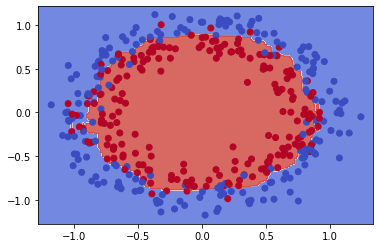

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

# Stacking
- 앙상블의 한 종류로서 여러개의 서로 다른 모델을 이용해서 정확도를 높이는 방법
- 신경망(NN)처럼 여러개의 모델을 층층히 쌓아서 정확도를 높이는 방법
  - 최근에 캐글에서 좋은 성적으로 내기 시작하면서 잘 알려진 방법
  - 신경망 처럼 모형의 복잡도를 올려서 정확도를 높이는 방법
- 앙상블의 앙상블 기법이라고도 부릅니다. 

![](https://blog.kakaocdn.net/dn/qlNM8/btqGfNTsXAK/wZKuqNJXtceJw4eMIdqLjK/img.png)

- 책은 스택킹을 직접 구현하였지만, 그럴 필요 없으므로, 라이브러리를 이용해서 구현
- 결과 보다는 어떻게 스택킹을 구성할 수 있는지 정도만 익혀두시면 좋을 것 같습니다.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [ ]:
# base learner
estimators = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('RandomForest', RandomForestClassifier() ),
  ('XGBoost', xgb.XGBClassifier() ), 
  ('LGBM', lgb.LGBMClassifier() ),
  ('CB', cb.CatBoostClassifier() )
]

# meta learner
model = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression() )
model.fit(x, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.6805132	total: 4.6ms	remaining: 916ms
5:	learn: 0.6783412	total: 5.64ms	remaining: 935ms
6:	learn: 0.6762476	total: 6.76ms	remaining: 959ms
7:	learn: 0.6738612	total: 7.8ms	remaining: 967ms
8:	learn: 0.6719161	total: 8.84ms	remaining: 973ms
9:	learn: 0.6698101	total: 9.9ms	remaining: 980ms
10:	learn: 0.6683043	total: 10.9ms	remaining: 980ms
11:	learn: 0.6661109	total: 11.9ms	remaining: 983ms
12:	learn: 0.6639508	total: 13ms	remaining: 983ms
13:	learn: 0.6619727	total: 14ms	remaining: 984ms
14:	learn: 0.6587265	total: 15ms	remaining: 987ms
15:	learn: 0.6571963	total: 16.1ms	remaining: 989ms
16:	learn: 0.6550666	total: 17.1ms	remaining: 990ms
17:	learn: 0.6529677	total: 18.1ms	remaining: 989ms
18:	learn: 0.6511531	total: 19.2ms	remaining: 992ms
19:	learn: 0.6501256	total: 20.3ms	remaining: 993ms
20:	learn: 0.6473191	total: 21.3ms	remaining: 993ms
21:	learn: 0.6448870	total: 22.4ms	remaining: 995ms
22:	learn: 0.6428312	total: 23.4ms	remainin

StackingClassifier(estimators=[('RandomForest', RandomForestClassifier()),
                               ('XGBoost', XGBClassifier()),
                               ('LGBM', LGBMClassifier()),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x7fb33bffd090>)],
                   final_estimator=LogisticRegression())

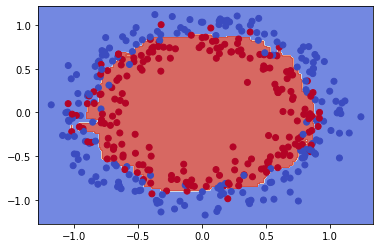

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## 여러개의 레이어
- 신경망 처럼 여러개의 Base Learner를 다양한 층으로 구분해서 쌓을수 있습니다.
- 또한 교차검층까지 지원하기 때문에 같이 사용해볼 수 있습니다. 

In [ ]:
# base learner
estimators_one = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('RandomForest', RandomForestClassifier() ),
  ('XGBoost', xgb.XGBClassifier() ), 
  ('LGBM', lgb.LGBMClassifier() ),
  ('CB', cb.CatBoostClassifier() )
]

estimators_two = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('SVM', SVC() ),
  ('KNN', KNeighborsClassifier() ), 
]

# meta learner
layer_two = StackingClassifier( estimators=estimators_two, final_estimator=LogisticRegression() )
model = StackingClassifier( estimators=estimators_one, final_estimator=layer_two, cv=10 )
model.fit(x, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.6799400	total: 11.3ms	remaining: 2.25s
5:	learn: 0.6770959	total: 14.1ms	remaining: 2.33s
6:	learn: 0.6752767	total: 16.9ms	remaining: 2.4s
7:	learn: 0.6729561	total: 18.8ms	remaining: 2.33s
8:	learn: 0.6705935	total: 19.9ms	remaining: 2.19s
9:	learn: 0.6683467	total: 21ms	remaining: 2.08s
10:	learn: 0.6658323	total: 22ms	remaining: 1.98s
11:	learn: 0.6636745	total: 23.1ms	remaining: 1.9s
12:	learn: 0.6617715	total: 24.1ms	remaining: 1.83s
13:	learn: 0.6594686	total: 25.2ms	remaining: 1.78s
14:	learn: 0.6564725	total: 26.3ms	remaining: 1.72s
15:	learn: 0.6543349	total: 27.3ms	remaining: 1.68s
16:	learn: 0.6519599	total: 28.3ms	remaining: 1.64s
17:	learn: 0.6503264	total: 29.4ms	remaining: 1.6s
18:	learn: 0.6484292	total: 30.4ms	remaining: 1.57s
19:	learn: 0.6464860	total: 31.5ms	remaining: 1.54s
20:	learn: 0.6444608	total: 32.5ms	remaining: 1.52s
21:	learn: 0.6421975	total: 33.6ms	remaining: 1.49s
22:	learn: 0.6404934	total: 34.6ms	remain

StackingClassifier(cv=10,
                   estimators=[('RandomForest', RandomForestClassifier()),
                               ('XGBoost', XGBClassifier()),
                               ('LGBM', LGBMClassifier()),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x7fb33c014690>)],
                   final_estimator=StackingClassifier(estimators=[('SVM',
                                                                   SVC()),
                                                                  ('KNN',
                                                                   KNeighborsClassifier())],
                                                      final_estimator=LogisticRegression()))

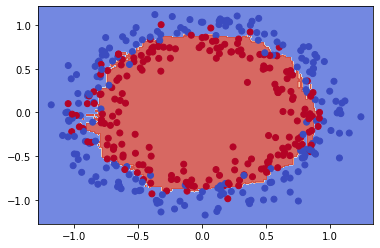

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

- 굳이 여러개의 레이어로 나눌 필요는 없습니다.
- 여기서는 다양하게 스택킹을 구성할 수 있다 정도로만 이해해 두시면 될 것 같습니다. 